In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report, r2_score
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
# Cargar CSV en un DataFrame
df = pd.read_csv("processed_data/athlete_events_clean_final.csv")

In [4]:
df

,ID,Sex,Age,Height,Weight,Team,Games,City,Sport,Medal,Medal_num,Medal_bin
0,1,M,24.0,180.0,80.0,China,1992 Summer,Barcelona,Basketball,No medal,0,0
1,2,M,23.0,170.0,60.0,China,2012 Summer,London,Judo,No medal,0,0
2,5,F,21.0,185.0,82.0,Netherlands,1988 Winter,Calgary,Speed Skating,No medal,0,0
3,5,F,21.0,185.0,82.0,Netherlands,1988 Winter,Calgary,Speed Skating,No medal,0,0
4,5,F,25.0,185.0,82.0,Netherlands,1992 Winter,Albertville,Speed Skating,No medal,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
178350,135569,M,29.0,179.0,89.0,Poland,1976 Winter,Innsbruck,Luge,No medal,0,0
178351,135570,M,27.0,176.0,59.0,Poland,2014 Winter,Sochi,Ski Jumping,No medal,0,0
178352,135570,M,27.0,176.0,59.0,Poland,2014 Winter,Sochi,Ski Jumping,No medal,0,0
178353,135571,M,30.0,185.0,96.0,Poland,1998 Winter,Nagano,Bobsleigh,No medal,0,0


In [5]:
#En este modelo base vamos a intentar ver como seria nuestro proyecto si unicamente necesitamos predecir clases binarias (medalla/no medalla)

X = df.drop(['Medal', 'Medal_num','Medal_bin'], axis=1)
y = df['Medal_bin']

cat_cols = X.select_dtypes(include=["object"]).columns
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
num_cols1 = ["Age","Height","Weight"]

In [ ]:
#dividimos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#Guardar train y test en CSV 
train_set = X_train.copy()
train_set['Medal_bin'] = y_train
train_set.to_csv('train/train_set_bin.csv', index=False)

test_set = X_test.copy()
test_set['Medal_bin'] = y_test
test_set.to_csv('test/test_set_bin.csv', index=False)

In [7]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(142684, 9)
(35671, 9)
(142684,)
(35671,)


In [8]:
#Creamos la matriz de correlación y para ello hacemos un preprocesamiento de datos para convertir variables categoricas con TargetEncoder

corr_preprocessor = ColumnTransformer(
    transformers=[
        ("cat", TargetEncoder(), cat_cols),
        ("num", StandardScaler(), num_cols)
    ],
    remainder='drop'
)

corr_preprocessor.fit(X_train, y_train)
X_train_corr = corr_preprocessor.transform(X_train)

df_corr = pd.DataFrame(
    X_train_corr,
    columns=list(cat_cols) + list(num_cols)
)
df_corr["Medal_bin"] = y_train.values

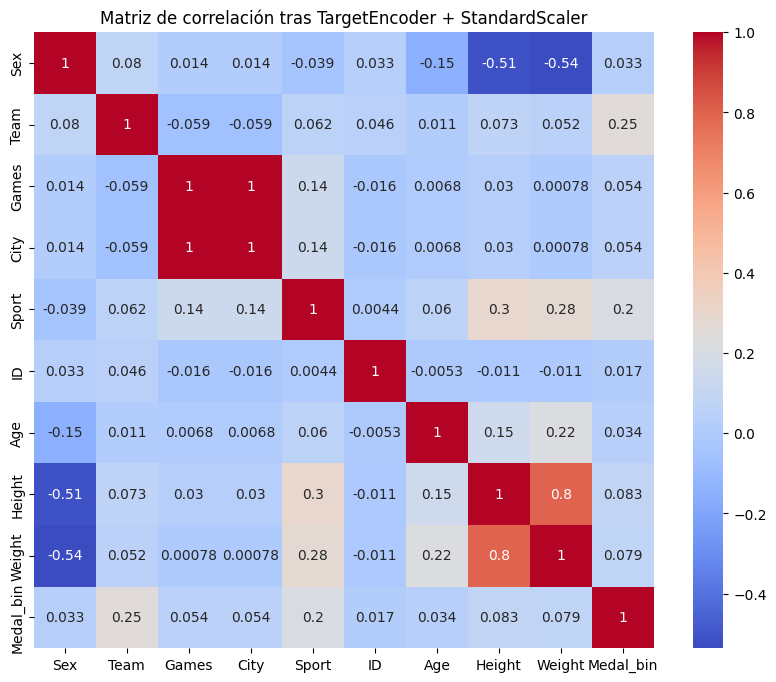

In [9]:
corr = df_corr.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Matriz de correlación tras TargetEncoder + StandardScaler")
plt.show()

In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", TargetEncoder(), cat_cols),
        ("num", StandardScaler(), num_cols),
    ],
    remainder='drop'
)

In [11]:
#Como usamos la tecnica de SMOTE despues del preprocessor, necesitamos el modulo ImbPipeline ya que el Pipeline no trata bien el SMOTE.

pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', RandomForestClassifier(
        n_estimators=300,
        max_depth=6,
        min_samples_leaf = 10,
        class_weight="balanced",  #para que ponga cariño a las clases minoritarias
        random_state=42,
        n_jobs=-1
    ))
])

In [12]:
pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [13]:
y_pred_train = pipeline.predict(X_train)

y_proba_train = pipeline.predict_proba(X_train)


In [14]:
# Métricas de evaluación train con SMOTE
accuracy = round(accuracy_score(y_train, y_pred_train),2)
f1 = round(f1_score(y_train, y_pred_train, average='weighted'),2)
precision = round(precision_score(y_train, y_pred_train, average='weighted'),2)
recall = round(recall_score(y_train, y_pred_train, average='weighted'),2)
conf_matrix = confusion_matrix(y_train, y_pred_train)


print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Matriz de Confusión:\n", conf_matrix)
print("\nReporte de clasificación:\n", classification_report(y_train, y_pred_train))
print("\nMatriz de probabilidad:\n",y_proba_train)

#Accuracy y Recall: aumentan significativamente en el binario → más fácil predecir solo medalla/no medalla que diferenciar entre tipos de medalla.
#F1 Score y Precision: también mejoran → menos confusión entre clases minoritarias.
#Interpretación: Reducir la complejidad de la tarea (de 4 clases a 2) ayuda a que SMOTE y el modelo manejen mejor el desbalance y aumenten la efectividad.

Accuracy: 0.74
F1 Score: 0.77
Precision: 0.83
Recall: 0.74
Matriz de Confusión:
 [[94797 28416]
 [ 8575 10896]]

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.92      0.77      0.84    123213
           1       0.28      0.56      0.37     19471

    accuracy                           0.74    142684
   macro avg       0.60      0.66      0.60    142684
weighted avg       0.83      0.74      0.77    142684


Matriz de probabilidad:
 [[0.70854258 0.29145742]
 [0.34084551 0.65915449]
 [0.75884804 0.24115196]
 ...
 [0.85671892 0.14328108]
 [0.5687844  0.4312156 ]
 [0.63603045 0.36396955]]


In [15]:
#vamos a intentar comparar con un SMOTE avanzado.

pipeline_1 = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTETomek(random_state=42)), #Aqui remplazamos Smote por SmoteTomek
    ('model', RandomForestClassifier(
        n_estimators=300,
        max_depth=6,
        min_samples_leaf = 10,
        class_weight="balanced",  #para que ponga cariño a las clases minoritarias
        random_state=42,
        n_jobs=-1
    ))
])

In [16]:
pipeline_1.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [17]:
y_pred_train_balanced = pipeline_1.predict(X_train)

y_proba_train_balanced = pipeline_1.predict_proba(X_train)

In [18]:
# Métricas de evaluación train utilizando SMOTETomek
accuracy = round(accuracy_score(y_train, y_pred_train_balanced),2)
f1 = round(f1_score(y_train, y_pred_train_balanced, average='weighted'),2)
precision = round(precision_score(y_train, y_pred_train_balanced, average='weighted'),2)
recall = round(recall_score(y_train, y_pred_train_balanced, average='weighted'),2)
conf_matrix = confusion_matrix(y_train, y_pred_train_balanced)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Matriz de Confusión:\n", conf_matrix)
print("\nReporte de clasificación:\n", classification_report(y_train, y_pred_train_balanced))
print("\nMatriz de probabilidad:\n",y_proba_train_balanced)

#Accuracy y F1 Score se mantienen prácticamente iguales.
#Recall de la clase 1 (medalla) disminuye notablemente con SMOTETomek (0.57 vs 0.74 con SMOTE simple).
#Precision permanece igual → el modelo sigue siendo bueno identificando verdaderos positivos, pero ahora detecta menos atletas con medalla.
#matriz de confusion:
#Clase 0 (sin medalla) → 77% correctos, similar a SMOTE simple.
#Clase 1 (medalla) → 57% correctos, notable caída respecto al 74% de SMOTE simple.
#Error mayor en la clase minoritaria (medalla) → SMOTETomek parece más agresivo con el undersampling de la mayoría, afectando la sensibilidad a positivos.

Accuracy: 0.74
F1 Score: 0.77
Precision: 0.83
Recall: 0.74
Matriz de Confusión:
 [[94270 28943]
 [ 8454 11017]]

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.92      0.77      0.83    123213
           1       0.28      0.57      0.37     19471

    accuracy                           0.74    142684
   macro avg       0.60      0.67      0.60    142684
weighted avg       0.83      0.74      0.77    142684


Matriz de probabilidad:
 [[0.71367    0.28633   ]
 [0.33456048 0.66543952]
 [0.74856812 0.25143188]
 ...
 [0.85540351 0.14459649]
 [0.57028155 0.42971845]
 [0.63475935 0.36524065]]


In [19]:
#Vamos a implementar tecnicas de undersampling a ver que tal

pipeline_2 = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('undersample', RandomUnderSampler(random_state=42) ),
    ('model', RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced"
    ))
])

In [20]:
pipeline_2.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('undersample', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [21]:
y_pred_train_balanced_under = pipeline_2.predict(X_train)

y_proba_train_balanced_under = pipeline_2.predict_proba(X_train)

In [22]:
# Métricas de evaluación train utilizando UnderSampling
accuracy = round(accuracy_score(y_train, y_pred_train_balanced_under),2)
f1 = round(f1_score(y_train, y_pred_train_balanced_under, average='weighted'),2)
precision = round(precision_score(y_train, y_pred_train_balanced_under, average='weighted'),2)
recall = round(recall_score(y_train, y_pred_train_balanced_under, average='weighted'),2)
conf_matrix = confusion_matrix(y_train, y_pred_train_balanced_under)
r2 = round(r2_score(y_train, y_pred_train_balanced_under),2)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Matriz de Confusión:\n", conf_matrix)
print("\nReporte de clasificación:\n", classification_report(y_train, y_pred_train_balanced_under))
print("\nMatriz de probabilidad:\n",y_proba_train_balanced_under)

#Accuracy es mejor que SMOTE y SMOTETomek  (0.80 vs 0.74).
#F1 Score también mejora, reflejando un mejor balance entre precisión y recall.
#Precision muy alta (0.92) → el modelo identifica correctamente la mayoría de los verdaderos negativos (sin medalla) y evita falsos positivos.
#Recall de 0.80 → captura bien la clase minoritaria (medalla) y mejora respecto a SMOTETomek  (0.57).
#Esto sugiere que undersampling favorece un modelo más balanceado entre clases, reduciendo la dominancia de la clase mayoritaria.
#El modelo sacrifica algunos ejemplos de la clase mayoritaria para mejorar la detección de medallas.

Accuracy: 0.8
F1 Score: 0.83
Precision: 0.92
Recall: 0.8
Matriz de Confusión:
 [[95474 27739]
 [  365 19106]]

Reporte de clasificación:
               precision    recall  f1-score   support

           0       1.00      0.77      0.87    123213
           1       0.41      0.98      0.58     19471

    accuracy                           0.80    142684
   macro avg       0.70      0.88      0.72    142684
weighted avg       0.92      0.80      0.83    142684


Matriz de probabilidad:
 [[0.89277778 0.10722222]
 [0.18       0.82      ]
 [0.26503704 0.73496296]
 ...
 [0.99333333 0.00666667]
 [0.86938889 0.13061111]
 [0.05       0.95      ]]


In [23]:
#Por último, vamos a intentar hacer una combinación de Undersampling y Smote a ver si mejoramos aÚn mas. 

from collections import Counter
counter = Counter(y_train)
n_major = counter[0]

# Definimos proporciones
smote = SMOTE(sampling_strategy={1: int(n_major*0.5)}, random_state=42)


pipeline_3 = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', smote), 
    ('undersample', RandomUnderSampler(sampling_strategy={0: int(n_major*0.8)}, random_state=42)),
    ('model', RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced"
    ))
])

In [24]:
pipeline_3.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [25]:
y_pred_train_mix_balanced = pipeline_3.predict(X_train)

y_proba_train_mix_balanced = pipeline_3.predict_proba(X_train)

In [26]:
# Métricas de evaluación train utilizando UnderSampling + SMOTE
accuracy = round(accuracy_score(y_train, y_pred_train_mix_balanced),2)
f1 = round(f1_score(y_train, y_pred_train_mix_balanced, average='weighted'),2)
precision = round(precision_score(y_train, y_pred_train_mix_balanced, average='weighted'),2)
recall = round(recall_score(y_train, y_pred_train_mix_balanced, average='weighted'),2)
conf_matrix = confusion_matrix(y_train, y_pred_train_mix_balanced)
r2 = round(r2_score(y_train, y_pred_train_mix_balanced),2)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Matriz de Confusión:\n", conf_matrix)
print("\nReporte de clasificación:\n", classification_report(y_train, y_pred_train_mix_balanced))
print("\nMatriz de probabilidad:\n",y_proba_train_mix_balanced)

#Métricas extremadamente altas en entrenamiento, cercanas a 1. Overfitting??
#F1, Precision y Recall balanceados, indicando que el modelo aprendió a distinguir muy bien ambas clases en el train.
# El dataset se balancea casi perfectamente, por lo que el modelo tiene ejemplos suficientes de la clase minoritaria y no es dominado por la mayoritaria.

#Matriz de confusión:
#Clase 0: 120105 de 123213 correctamente identificados → recall ~0.97.
#Clase 1: 18045 de 19471 correctamente identificados → recall ~0.93.
#La clase minoritaria (medalla) tiene muy buen soporte y apenas se pierden positivos.
#La clase mayoritaria se ve ligeramente reducida por undersampling, pero sigue bien representada.

Accuracy: 0.97
F1 Score: 0.97
Precision: 0.97
Recall: 0.97
Matriz de Confusión:
 [[120105   3108]
 [  1426  18045]]

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98    123213
           1       0.85      0.93      0.89     19471

    accuracy                           0.97    142684
   macro avg       0.92      0.95      0.93    142684
weighted avg       0.97      0.97      0.97    142684


Matriz de probabilidad:
 [[0.99       0.01      ]
 [0.50045641 0.49954359]
 [0.68431148 0.31568852]
 ...
 [1.         0.        ]
 [0.97657616 0.02342384]
 [0.10724138 0.89275862]]


In [27]:
y_pred_test_mix_balanced = pipeline_3.predict(X_test)

y_proba_test_mix_balanced = pipeline_3.predict_proba(X_test)

In [28]:
# Métricas de evaluación test utilizando UnderSampling + SMOTE
accuracy = round(accuracy_score(y_test, y_pred_test_mix_balanced),2)
f1 = round(f1_score(y_test, y_pred_test_mix_balanced, average='weighted'),2)
precision = round(precision_score(y_test, y_pred_test_mix_balanced, average='weighted'),2)
recall = round(recall_score(y_test, y_pred_test_mix_balanced, average='weighted'),2)
conf_matrix = confusion_matrix(y_test, y_pred_test_mix_balanced)
r2 = round(r2_score(y_test, y_pred_test_mix_balanced),2)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Matriz de Confusión:\n", conf_matrix)
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred_test_mix_balanced))
print("\nMatriz de probabilidad:\n",y_proba_test_mix_balanced)

#Muy buen desempeño general en test.
#Accuracy y F1 cercanos, lo que indica balance razonable entre precisión y recall.
#Mejor que los modelos binarios con SMOTE o undersampling por separado.

#Matriz de confusión
#Se observa que el modelo todavía tiende a favorecer la clase mayoritaria en test, aunque es mucho mejor que SMOTE solo o undersampling solo.
# mejora representación de la clase minoritaria en train, pero el test sigue teniendo distribución real desequilibrada.

#Se puede observar un overfitting parcial, probablemente debido a SMOTE y undersampling que generaron ejemplos sintéticos muy similares al train. 

#Esto podria optimizarse dentro de un pipeline probando diferentes hiperparametros y modelos.

Accuracy: 0.89
F1 Score: 0.88
Precision: 0.88
Recall: 0.89
Matriz de Confusión:
 [[29393  1410]
 [ 2568  2300]]

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.92      0.95      0.94     30803
           1       0.62      0.47      0.54      4868

    accuracy                           0.89     35671
   macro avg       0.77      0.71      0.74     35671
weighted avg       0.88      0.89      0.88     35671


Matriz de probabilidad:
 [[0.80335044 0.19664956]
 [0.22437079 0.77562921]
 [0.95       0.05      ]
 ...
 [0.94666667 0.05333333]
 [0.95860974 0.04139026]
 [0.91511687 0.08488313]]
